# Generatin Art: Neural Style Transfer

###1.Setting up


In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
!ls "/content/drive/My Drive"

'Aadhar Anvesh 2023 (1).jpg'
'Aadhar Anvesh 2023.jpg'
 AADHAR_VG_2021.pdf
 AIML
 AnveshResume_BASE.gdoc
'Assignment tracker.gsheet'
'be0c88a381c2baa8dff2f3e2cf81d45265defcc776211-registration (1).gsheet'
'be0c88a381c2baa8dff2f3e2cf81d45265defcc776211-registration (2).gsheet'
 be0c88a381c2baa8dff2f3e2cf81d45265defcc776211-registration.csv
 be0c88a381c2baa8dff2f3e2cf81d45265defcc776211-registration.gsheet
 car_evaluation.csv
 Classroom
'Colab Notebooks'
'Copy of Assignment tracker.gsheet'
'Copy of Dataset.gsheet'
'Copy of Evolute, 2024 Template.gsheet'
'Copy of FINANCIALCRICKETCOPY.xlsx'
'Copy of Share Trading account Archana ICICI.xlsx'
'Copy of TNP_SAMPLE_RESUME.gdoc'
'CORPO SIAM(ANVESH).gsheet'
'CSP_INIT_DAILY_14062024 (1).csv'
 CSP_INIT_DAILY_14062024.csv
 DATA_RAW.gsheet
 DOCUMENTS.pdf
'ECELL CORPO(ANVESH).gsheet'
 FINANCIALCRICKETCOPY.xlsx
 FINANCIALCRICKET.xlsx
 fincricket.gsheet
'holdings-UYR523 2.xlsx'
 IMG_0522.jpg
 IMG_20220927_135558.jpg
 IMG_20221025_152313.jpg
 INIT_UPDATES

Python looks for modules in specific directories defined in the sys.path variable. If the 'public_tests' module is located in a directory not included in this path, it won't be found. thus, **to import from another file we need to make this sys path** .

In [58]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
sys.path.append('/content/drive/My Drive/Colab Notebooks/NST')
from public_tests import *
%matplotlib inline

<a name='2'></a>
## 2 - GOAL

Using Neural style transfer optimization to generate art by merging two images, namely: <strong>"content" image (C)</strong> and <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S.

<a name='3'></a>
## 3 - Transfer Learning

The pretrained network VCG-19, which is trained on the ImageNet database is used.

[Orignal NST paper](https://arxiv.org/abs/1508.06576)

In [59]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
weights_path='/content/drive/MyDrive/Colab Notebooks/NST/pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg = tf.keras.applications.VGG19(include_top=False,input_shape=(img_size, img_size, 3),weights=weights_path)
vgg.trainable = False
pp.pprint(vgg)

<a name='4'></a>
## 4 - Neural Style Transfer (NST)
The following are the components of the NST:
- Content Cost Function $J_{content}(C,G)$
- Style Cost Function $J_{style}(S,G)$
- Net Cost function $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.

<a name='4-1'></a>
### 4.1 - Computing the Content Cost

The content image (C) is:


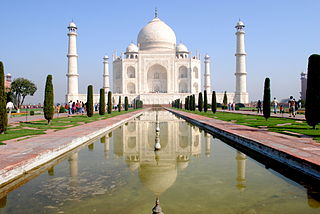

In [ ]:
content_image = Image.open("/content/drive/MyDrive/Colab Notebooks/NST/images/taj_mahal.jpeg")
print("The content image (C) is:")
content_image

<a name='4-1-2'></a>
#### 4.1.1 - Content Cost Function $J_{content}(C,G)$
The goal is for when performing NST is for the content in generated image G to match the content of image C.

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$


In [60]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]

    _, n_H, n_W, n_C = a_G.shape[0],a_G.shape[1],a_G.shape[2],a_G.shape[3]

    a_C_unrolled = tf.reshape(a_C,[n_C,n_H*n_W])
    a_G_unrolled = tf.reshape(a_G,[n_C,n_H*n_W])

    J_content = tf.reduce_sum(tf.square((a_C_unrolled)-(a_G_unrolled)))
    J_content=J_content*(0.25)/(float(n_H*n_W*n_C))
    return J_content

In [ ]:
### you cannot edit this cell

###compute_content_cost_test(compute_content_cost)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
All tests passed


<a name='4-2'></a>
### 4.2 - Computing the Style Cost


<a name='4-2-1'></a>
#### 4.2.1 - Style Matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix."
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$.
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large.


In [62]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """

    GA = tf.matmul(A,tf.transpose(A))

    return GA

In [ ]:
### you cannot edit this cell

###gram_matrix_test(gram_matrix)

<a name='4-2-1'></a>
#### 4.2.1 - Style Cost


$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.



In [63]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    _, n_H, n_W, n_C = a_G.shape.as_list()

    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])
    a_G = tf.transpose(a_G)

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    factor = (.5 / (n_H * n_W * n_C)) ** 2
    J_style_layer = factor*tf.reduce_sum(tf.square(GS-GG))

    print(J_style_layer)
    return J_style_layer

In [ ]:
### you cannot edit this cell

###compute_layer_style_cost_test(compute_layer_style_cost)

<a name='4-2-3'></a>
#### 4.2.3 Style Weights

* Style costs from several different layers are merged together.
* Each layer will hvae weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.

The layer names:

In [64]:
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [74]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [101]:
STYLE_LAYERS = [
    ('block1_conv1', 0.1),
    ('block2_conv1', 0.3),
    ('block3_conv1', 0.3),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

The style costs for different layers are combined as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`.


In [102]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.




<a name='4-3'></a>
### 4.3 - Defining the Total Cost to Optimize

The total cost function formula is:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$



In [103]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """

    J = ((alpha*J_content)+(beta*J_style))

    return J

<a name='5'></a>
## 5 - Solving the Optimization Problem

<a name='5-1'></a>
### 5.1 Loading the Content Image:

(1, 400, 400, 3)


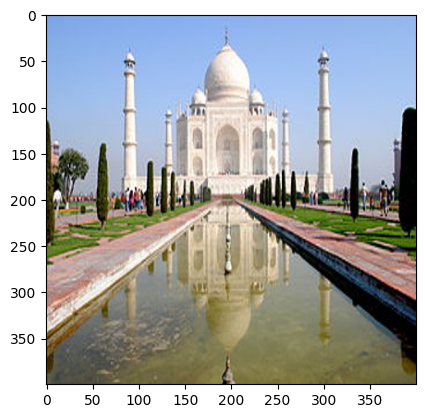

In [104]:
content_image = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/NST/images/taj_mahal.jpeg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### 5.2 Loading the Style Image:

(1, 400, 400, 3)


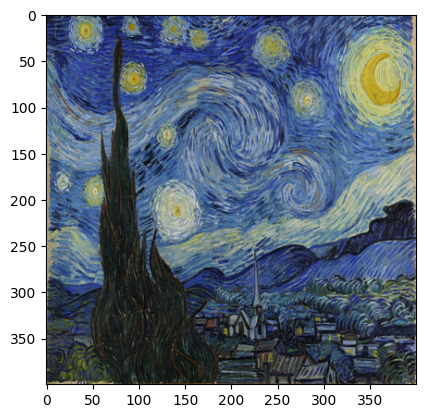

In [105]:
style_image =  np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/NST/images/final_style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### 5.3 Initializing the Image to be Generated

(1, 400, 400, 3)


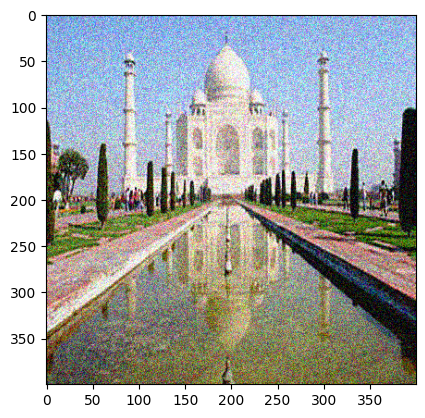

In [106]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## 5.4 - Loading Pre-trained VGG19 Model

In [107]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [108]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [109]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

<a name='5-5'></a>
### 5.5 - Computing Total Cost

<a name='5-5-1'></a>
#### 5.5.1 - Computing the Content image Encoding (a_C)


In [110]:
# Assign the content image to be the input of the VGG model.
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

<a name='5-5-2'></a>
#### 5.5.2 - Compute the Style image Encoding (a_S)


In [111]:
# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [112]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [113]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:


        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)

        J_style = compute_style_cost(a_S, a_G)

        J_content = compute_content_cost(a_C,a_G)

        J = total_cost(J_content,J_style)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

In [114]:
generated_image = tf.Variable(generated_image)


<a name='5-6'></a>
### 5.6 - Training the Model


In [115]:
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again
epochs = 15000
for i in range(epochs):
    train_step(generated_image)
    if i % 500 == 0:
        print(f"Epoch {i} ")
    if i % 500 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"/content/drive/MyDrive/Colab Notebooks/NST/output/image_{i}.jpg")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

###Results:


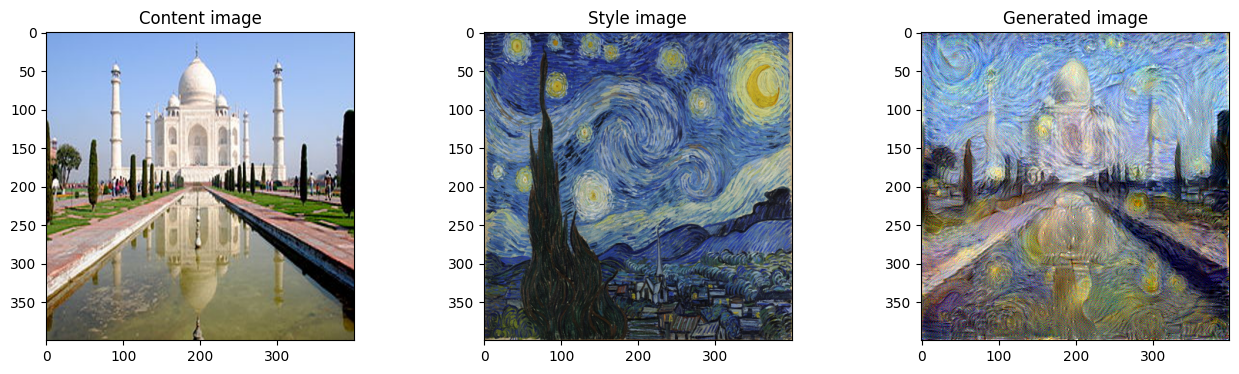

In [116]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

<a name='7'></a>
## 7 - References

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups this lab was inspired by. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team.

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
- [DeepLearning.ai](https://www.coursera.org/learn/convolutional-neural-networks)
